# Feature Selection

Feature selection is the process of selecting a subset of relevant features (variables, predictors) for use in estimator construction. The central premise when using a feature selection technique is that the data contains some features that are either **redundant** or **irrelevant**, and can thus be removed without incurring much loss of information

Feature section is importan for several reasons:

- simplification of estimators to make them easier to interpret,
- reduction of the computational cost of modeling (shorter training times),
- reduction of the economic cost when generating features that require expensive services,
- to improve the performance of the model,
- to avoid the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality),
- improve data's compatibility with a learning model class,
- encode inherent symmetries present in the input space

Feature selection is also related to dimensionally reduction techniques in that both methods seek fewer input variables to a predictive model. The difference is that feature selection select features to keep or remove from the dataset, whereas dimensionality reduction create a projection of the data resulting in entirely new input features. As such, dimensionality reduction is an alternate to feature selection rather than a type of feature selection.

Feature selection methods can be classified as follows:

- Unsupervised: Do not use the target variable (e.g. remove redundant or biased variables).
    - Correlation (filter-based)
    - Variance Threshold
- Supervised: Use the target variable (e.g. remove irrelevant variables).
    - Wrapper: Search for well-performing subsets of features.
        - Recursive feature elimination (RFE)
        - Sequential feature selection (SFS)
    - Filter-based methods: Select subsets of features based on their relationship with the target.
        - Statistical Methods
        - Feature Importance Methods
    - Intrinsic: Algorithms that perform automatic feature selection during training.
        -Decision Trees
- Dimensionality Reduction: Project input data into a lower-dimensional feature space.

Resources:
- https://en.wikipedia.org/wiki/Feature_selection
- https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/
- https://scikit-learn.org/stable/modules/feature_selection.html
- https://sklearn-genetic-opt.readthedocs.io/en/stable/index.html

In [2]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

## Dataset
To illustrate differet feature selection methods we consider the [wine recognition dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html) which is a toy dataset with data that results from a chemical analysis of wines grown in the same region in Italy by three different cultivators. There are thirteen different measurements (features) taken for different constituents found in the three types of wine.

In [3]:
from sklearn.datasets import load_wine
from sklearn.preprocessing import LabelEncoder

dataset = load_wine()
m, n = dataset.data.shape
features = dataset.feature_names
print('The dataset contains %d samples and %d features:\n' %(m, n))
print(features)

df = pd.DataFrame(data=np.concatenate((dataset.data, dataset.target.reshape(m,1)), axis=1),
                     columns=dataset.feature_names + ['target'])

X = df[features]

le = LabelEncoder()
y = le.fit_transform(df['target'])

display(df)

The dataset contains 178 samples and 13 features:

['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0,2.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0,2.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0,2.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0,2.0


### Dataset description

#### Target

In [4]:
counter = Counter(y)
for k, count in counter.items():
	per = count / len(y) * 100
	print('Class=%d, n=%d (%.2f%%)' %(k, count, per))

Class=0, n=59 (33.15%)
Class=1, n=71 (39.89%)
Class=2, n=48 (26.97%)


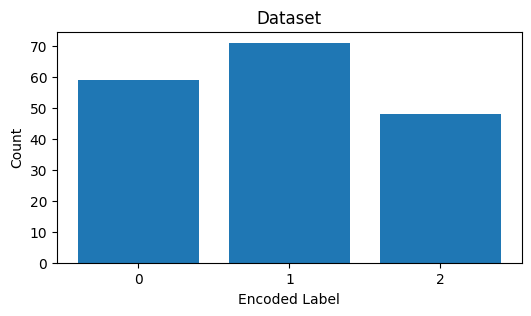

In [5]:
plt.figure(figsize=(6, 3))
plt.bar(counter.keys(), counter.values())   # type: ignore
plt.xticks([0, 1, 2], counter.keys())    # type: ignore
plt.xlabel('Encoded Label')
plt.ylabel('Count')
plt.title('Dataset')
plt.show()

#### Input

In [6]:
display(X.describe().T)

,count,mean,std,min,25%,50%,75%,max
alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
malic_acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
alcalinity_of_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
color_intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


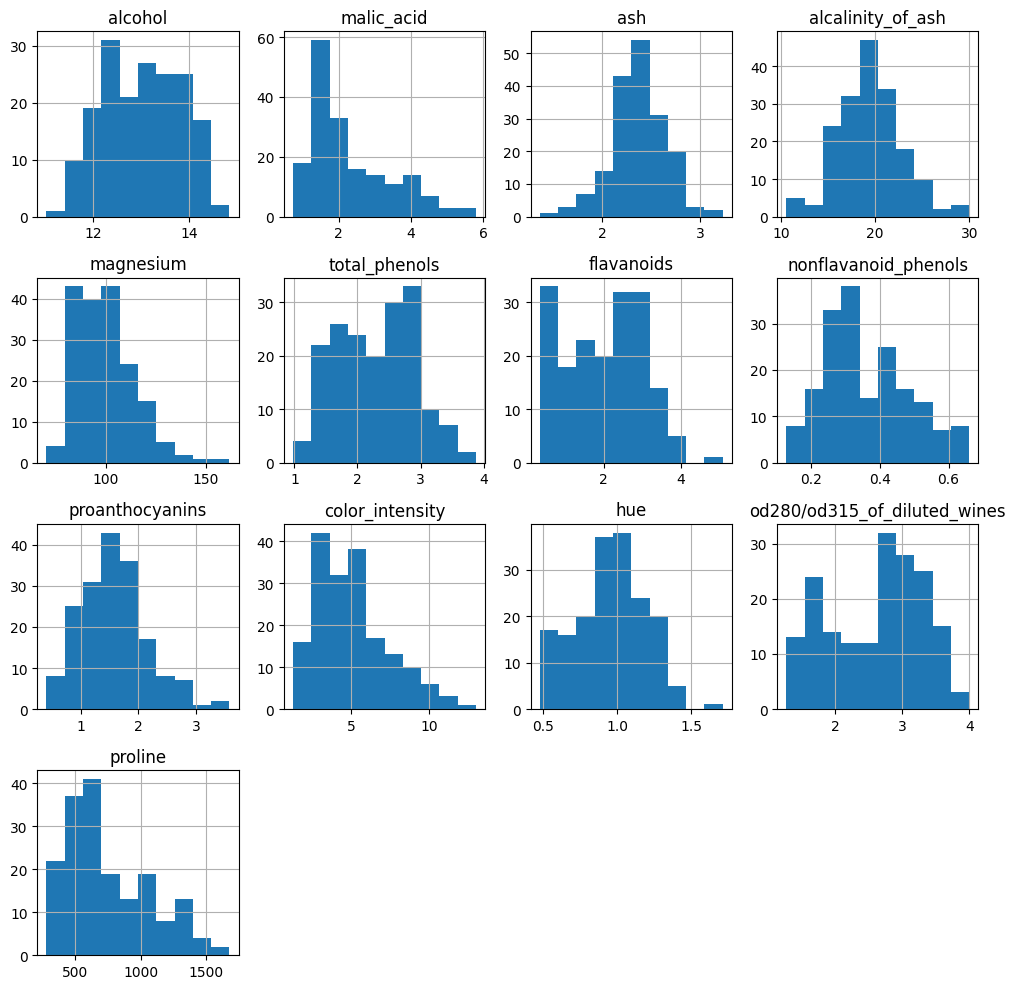

In [7]:
X.hist(figsize=(10, 10))
plt.tight_layout()
plt.show()

## Unsupervised feature Selection Methods

### Variance Threshold Feature Selection

A feature with a higher variance means that the value within that feature varies or has a high cardinality. On the other hand, lower variance means the value within the feature is similar, and zero variance means we have a feature with the same value. Intuitively, we want to have a varied feature as we don’t want our predictive model to be biased. That is why we could select the feature based on the variance we select previously.

A variance Threshold is a simple approach for eliminating features based on our expected variance within each feature. Although, there are some down-side to the variance threshold method as it only sees the input features $X$ without considering any information from the dependent variable $y$. It is only useful for eliminating features for unsupervised modelling rather than supervised modelling.

As a side note, normalized and unnormalized data have valid uses cases in [`VarianceThreshold`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.VarianceThreshold.html#sklearn.feature_selection.VarianceThreshold) method from the scikit-learn library:

- If you only want to use `VarianceThreshold` to remove constant features, then the parameter `threshold=0` works regardless if the data was normalized.
- If you want the threshold have the same meaning for features, then normalizing makes sense.

In [8]:
from sklearn.feature_selection import VarianceThreshold

# Scale features to the range [0 1]
sc = MinMaxScaler()
X_sc = sc.fit_transform(X)

selector = VarianceThreshold(threshold=0.03).fit(X_sc)
support = selector.get_support()

selected_vthr = X.columns[support].to_list()
discarted_vthr = X.columns[~support].to_list()

print('Features with higher variance:\n', selected_vthr)
print('Features with low variance:\n', discarted_vthr)

Features with higher variance:
 ['alcohol', 'malic_acid', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Features with low variance:
 ['ash', 'alcalinity_of_ash', 'magnesium']


### Correlation analysis

In many datasets we find some of the features which are highly correlated that means which are some what linearly dependent with other features. These features contribute very less in predicting the output but increses the computational cost. First lets see the correlation matrix:

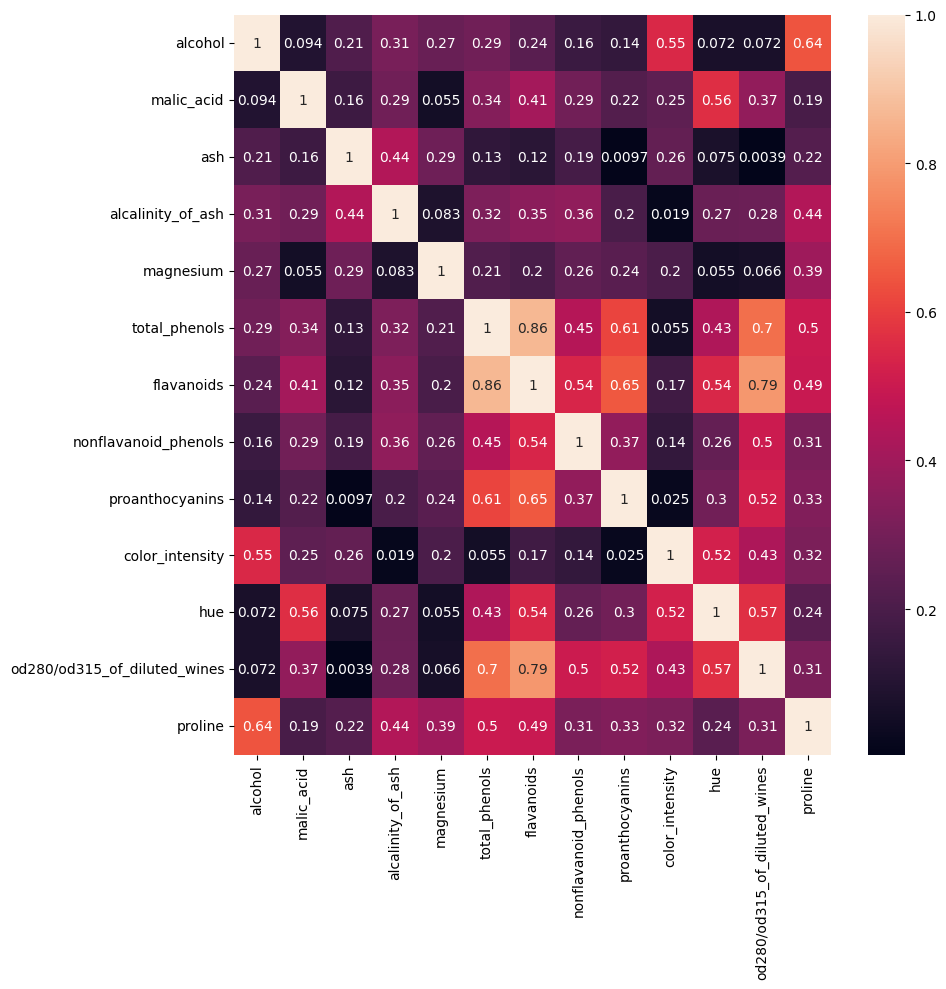

In [9]:
corr = X.corr().abs()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True)
plt.tight_layout()
plt.show()

So we have to find out the correlation between the features and remove the features which have correlation coefficient greater than a certain limit (threshold) as follows:

In [10]:
thr = 0.7 # Correlation threshold
support = np.full((corr.shape[0]), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= thr:
            if support[j]:
                support[j] = False

selected_corr = X.columns[support].to_list()
discarted_corr = X.columns[~support].to_list()

print('Independent features:\n', selected_corr)
print('Dependent features:\n', discarted_corr)

Independent features:
 ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'proline']
Dependent features:
 ['flavanoids', 'od280/od315_of_diluted_wines']


## Supervised feature Selection Methods

### Filter-Based Feature Selection Methods (univariate feature selection)

It is common to use correlation type statistical measures between input and output variables as the basis for filter feature selection. The choice of statistical test is highly dependent upon the variable data types, such as:

- Numerical Variables
    - Integer Variables
    - Floating Point Variables
- Categorical Variables
    - Boolean Variables (dichotomous)
    - Ordinal Variables
    - Nominal Variables

On the other hand, the type of response variable typically indicates the type of predictive modeling problem being performed. Thus, numerical output variable indicates a regression predictive modeling problem, and a categorical output variable indicates a classification predictive modeling problem

The statistical measures used in filter-based feature selection are generally calculated one input variable at a time with the target variable. As such, they are referred to as univariate statistical measures.

The following diagram is helpful for choosing a filter-based feature selection method

![filter-based](fig/filter_method_selection.png)

#### Numerical input, numerical output

This corresponds to a regression predictive modeling problem with numerical input variables. The most common techniques are correlation coefficient-based, such as:

- Pearson’s correlation coefficient for linear correlation
- Spearman’s rank coefficient for nonlinear correlation

#### Numerical input, categorical output

This is a classification predictive modeling problem with numerical input variables. This might be the most common example of a classification problem. Again, the most common techniques are correlation based, although in this case, they must take the categorical target into account. Thus we have:

- ANOVA correlation coefficient for linear correlation.
- Kendall’s rank coefficient for nonlinear correlation (assume that the categorical variable is ordinal).

#### Categorical input, numerical output

This is a regression predictive modeling problem with categorical input variables. This is a strange example of a regression problem (e.g. you would not encounter it often). Nevertheless, you can use the same "Numerical Input, Categorical Output" methods (described above), but in reverse.

#### Categorical input, categorical output

This is a classification predictive modeling problem with categorical input variables. The most common correlation measure for categorical data is the chi-squared test. You can also use mutual information (information gain) from the field of information theory.

- Chi-Squared test (contingency tables).
- Mutual Information.

In fact, mutual information is a powerful method that may prove useful for both categorical and numerical data, e.g. it is agnostic to the data types.

The scikit-learn library provides an implementation of most of the useful statistical measures. For example:

- Pearson's Correlation Coefficient: `f_regression()`
- ANOVA: `f_classif()`
- Chi-Squared: `chi2()`
- Mutual Information: `mutual_info_classif()` and `mutual_info_regression()`

The scikit-learn library also provides many different filtering methods once statistics have been calculated for each input variable with the target. Two of the more popular methods include:

- Select the top $k$ features: `SelectKBest`
- Select the top percentile features: `SelectPercentile`

For our example dataset we have numerical floating point variables with a categorical target variable. Thus we use `f_classif()` and `mutual_info_classif()`

In [11]:
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import f_classif, mutual_info_classif

# Select top k features
k = 11
selector = SelectKBest(f_classif, k=k).fit(X, y)
# selector = SelectKBest(mutual_info_classif, k=k).fit(X, y)
support = selector.get_support()

selected_kbest = X.columns[support].to_list()
discarted_kbest = X.columns[~support].to_list()

print('Top k features:\n', selected_kbest)
print('Discarted features:\n', discarted_kbest)

# Scores
feature_scores = {'feature': features, 'score':selector.scores_}
display(pd.DataFrame(data=feature_scores).sort_values('score', ascending=False))

Top k features:
 ['alcohol', 'malic_acid', 'alcalinity_of_ash', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Discarted features:
 ['ash', 'magnesium']


,feature,score
6,flavanoids,233.925873
12,proline,207.920374
11,od280/od315_of_diluted_wines,189.972321
0,alcohol,135.077624
9,color_intensity,120.664018
10,hue,101.316795
5,total_phenols,93.733010
1,malic_acid,36.943425
3,alcalinity_of_ash,35.771637
8,proanthocyanins,30.271383


Consider transforming the variables in order to access different statistical methods. For example, you can transform a categorical variable to ordinal, even if it is not, and see if any interesting results come out. You can also make a numerical variable discrete (e.g. bins); try categorical-based measures.

Some statistical measures assume properties of the variables, such as Pearson’s that assumes a Gaussian probability distribution to the observations and a linear relationship. You can transform the data to meet the expectations of the test and try the test regardless of the expectations and compare results.

### Intrinsic feature selection 

Intrinsic feature selection is based on algorithms that perform automatic feature selection during training. This feature selection method can be performed via the `SelectFromModel` method from the scikit-learn library. Like the `RFE`, the `SelectFromModel` is based on a machine learning model estimator that assigns importance to each feature through a specific attribute (such as `coef_`, `feature_importances_`) or via an `importance_getter` callable after fitting. The features are considered unimportant and removed if the corresponding importance of the feature values are below the provided threshold parameter ("mean", "median" and float multiples of these like "0.1*mean").

In [12]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

# Estimator
clf = ExtraTreesClassifier(n_estimators=50)
# Selecting the Best important features
selector = SelectFromModel(estimator=clf).fit(X, y)
support = selector.get_support()

selected_from_model = X.columns[support].to_list()
discarted_from_model = X.columns[~support].to_list()

print('Selected features:\n', selected_from_model)
print('Discarted features:\n', discarted_from_model)

Selected features:
 ['alcohol', 'flavanoids', 'color_intensity', 'od280/od315_of_diluted_wines', 'proline']
Discarted features:
 ['malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'nonflavanoid_phenols', 'proanthocyanins', 'hue']


### Wrapper methods

#### Recursive feature elimination
Recursive feature elimination (RFE) is a is a wrapper-type feature selection method that uses a machine learning model to select features by eliminating the least important feature after recursively training. This is achieved by fitting the given machine learning algorithm used in the core of the model, ranking features by importance, discarding the least important features, and re-fitting the model. This process is repeated until a specified number of features remains. 

According to scikit-learn, `RFE` is a method to select $k$ features by recursively considering smaller and smaller sets of features. First, the estimator is trained on the initial set of features, and the importance of each feature is obtained either through any specific attribute (such as `coef_`, `feature_importances_`) or callable of the model. Then, the least important features are pruned from the current set of features. That procedure is recursively repeated on the pruned set until the desired number of features to select is eventually reached.

This method only works if the model has `coef_` or `feature_importances_` attribute, if there are models out there having these attributes, we could apply `RFE` on scikit-learn. As an alternative the `RFECV` is an scikit-learn method for recursive feature elimination with automatic tuning of the number of features selected with cross-validation.

In [13]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

# Scale features to the range [0 1] (only for distance-based models)
sc = MinMaxScaler()
X_sc = sc.fit_transform(X)

# Estimator
clf = SVC(kernel="linear")

# Select the k best important features according to a classifier estimator.
min_features_to_select = 1  # Minimum number of features to consider
selector = RFECV(estimator=clf, 
                 cv=StratifiedKFold(2), 
                 scoring="accuracy", 
                 min_features_to_select=min_features_to_select, step=1)

selector.fit(X_sc, y)
support = selector.get_support()

selected_rfecv = X.columns[support].to_list()
discarted_rfecv = X.columns[~support].to_list()

print('Selected features:\n', selected_rfecv)
print('Discarted features:\n', discarted_rfecv)

Selected features:
 ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'flavanoids', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Discarted features:
 ['magnesium', 'total_phenols', 'nonflavanoid_phenols']


The following figure shows the `RFECV` curve, which reports the number of features vs. the cross validation score.

Optimal number of features : 10


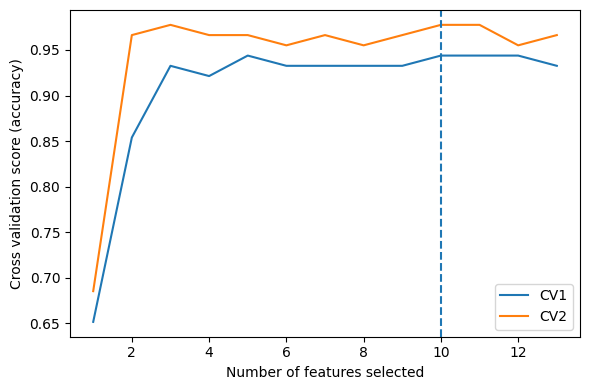

In [14]:
print("Optimal number of features : %d" % selector.n_features_)

n_features = range(min_features_to_select, n + min_features_to_select)
cv0_res = selector.cv_results_['split0_test_score'].reshape(n, 1)
cv1_res = selector.cv_results_['split1_test_score'].reshape(n, 1)
cv_res = np.concatenate((cv0_res, cv1_res), axis=1)

plt.figure(figsize=(6, 4))
plt.plot(n_features, cv_res)
plt.axvline(selector.n_features_, linestyle='--')

plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.legend(['CV1', 'CV2'])

plt.tight_layout()
plt.show()

#### Sequential feature setion

Sequential Feature Selection (SFS) is the other wrapper-type feature selection method that can be either forward or backward:

Forward-SFS is a greedy procedure that iteratively finds the best new feature to add to the set of selected features. Concretely, we initially start with zero features and find the one feature that maximizes a cross-validated score when an estimator is trained on this single feature. Once that first feature is selected, we repeat the procedure by adding a new feature to the set of selected features. The procedure stops when the desired number of selected features is reached.

Backward-SFS follows the same idea but works in the opposite direction: instead of starting with no features and greedily adding features, we start with all the features and greedily remove features from the set.

The `SFS` from the the scikit-learn library differs from `RFE` and `SelectFromModel` in that it does not require the underlying model to expose a `coef_` or `feature_importances_` attribute.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector

# Scale features to the range [0 1] (only for distance-based models)
sc = MinMaxScaler()
X_sc = sc.fit_transform(X)

# Estimator
clf = LogisticRegression()

#Selecting the 11 Best important features according to Logistic Regression
k = 11
selector = SequentialFeatureSelector(estimator=clf,
                                     n_features_to_select=k,
                                     cv=2,
                                     direction ='backward')

selector.fit(X_sc, y)
support = selector.get_support()

selected_sfs = X.columns[support].to_list()
discarted_sfs = X.columns[~support].to_list()

print('Selected features:\n', selected_sfs)
print('Discarted features:\n', discarted_sfs)

Selected features:
 ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']
Discarted features:
 ['nonflavanoid_phenols', 'proanthocyanins']


#### Genetic algorithm-based feature selection

Metaheuristics optimization for feature selection is a common approach to obtain an optimal subset of features. The way the feature selection is performed is by creating models with a subsample of features and evaluate its cv-score, the way the subsets are created is by using the available evolutionary algorithms. It also tries to minimize the number of selected features, so it’s a multi-objective optimization.

In [16]:
from sklearn.svm import SVC
from sklearn_genetic import GAFeatureSelectionCV

# Scale features to the range [0 1] (only for distance-based models)
sc = MinMaxScaler()
X_sc = sc.fit_transform(X)

# Estimator
clf = SVC(kernel="linear")

selector = GAFeatureSelectionCV(estimator=clf,
                                cv=2,
                                scoring="accuracy",
                                population_size=30,
                                generations=20,
                                n_jobs=-1,
                                verbose=True,
                                keep_top_k=2,
                                elitism=True)

selector.fit(X_sc, y)
support = selector.best_features_

selected_ga = X.columns[support].to_list()
discarted_ga = X.columns[~support].to_list()

print('Selected features:\n', selected_ga)
print('Discarted features:\n', discarted_ga)

c:\Users\aleja\Python\machine_learning\ml_topics\.venv\Lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	30    	0.862547	0.0793937  	0.960674   	0.646067   
1  	60    	0.926404	0.0210381  	0.960674   	0.882022   
2  	60    	0.947191	0.0136537  	0.960674   	0.910112   
3  	60    	0.955805	0.00829907 	0.966292   	0.938202   
4  	60    	0.960487	0.00512507 	0.966292   	0.94382    
5  	60    	0.962921	0.00275224 	0.966292   	0.960674   
6  	60    	0.966292	0.00502487 	0.983146   	0.960674   
7  	60    	0.969288	0.00829907 	0.983146   	0.949438   
8  	60    	0.976966	0.00812182 	0.983146   	0.966292   
9  	60    	0.980899	0.00572924 	0.983146   	0.966292   
10 	60    	0.982772	0.00201692 	0.983146   	0.97191    
11 	60    	0.982772	0.00201692 	0.983146   	0.97191    
12 	60    	0.982772	0.00201692 	0.983146   	0.97191    
13 	60    	0.982772	0.00201692 	0.983146   	0.97191    
14 	60    	0.98221 	0.00357771 	0.983146   	0.966292   
15 	60    	0.982772	0.00201692 	0.983146   	0.97191    
16 	60    	0.983146	6.66134e-16	0.983146   	0.98

## Model performance

### Variance threshold feature selection

In [17]:
# Splitting
X_train, X_test, y_train, y_test = train_test_split(X[selected_vthr], y, 
                                                    test_size=0.33, 
                                                    random_state=0)

# Create an xgboost regression model
XGBparams = {'n_estimators': 70,
             'max_depth': 6,
             'learning_rate': 0.3002,
             'gamma': 0.01, 
             'reg_alpha': 0, 
             'reg_lambda': 1, 
             'base_score': 0.5,
             'random_state': 123}

estimator = XGBClassifier(**XGBparams)
estimator.fit(X_train,y_train)

y_predict = estimator.predict(X_test)
print('accuracy score: %.4f with %d selected features' %(accuracy_score(y_test,y_predict), len(selected_vthr)))

accuracy score: 0.9831 with 10 selected features


### Correlation analysis feature selection

In [18]:
# Splitting
X_train, X_test, y_train, y_test = train_test_split(X[selected_corr], y, 
                                                    test_size=0.33, 
                                                    random_state=0)

# Create an xgboost regression model
XGBparams = {'n_estimators': 70,
             'max_depth': 6,
             'learning_rate': 0.3002,
             'gamma': 0.01, 
             'reg_alpha': 0, 
             'reg_lambda': 1, 
             'base_score': 0.5,
             'random_state': 123}

estimator = XGBClassifier(**XGBparams)
estimator.fit(X_train,y_train)

y_predict = estimator.predict(X_test)
print('accuracy score: %.4f with %d selected features' %(accuracy_score(y_test,y_predict), len(selected_corr)))

accuracy score: 0.9661 with 11 selected features


### Univariate feature selection

In [19]:
# Splitting
X_train, X_test, y_train, y_test = train_test_split(X[selected_kbest], y, 
                                                    test_size=0.33, 
                                                    random_state=0)

# Create an xgboost regression model
XGBparams = {'n_estimators': 70,
             'max_depth': 6,
             'learning_rate': 0.3002,
             'gamma': 0.01, 
             'reg_alpha': 0, 
             'reg_lambda': 1, 
             'base_score': 0.5,
             'random_state': 123}

estimator = XGBClassifier(**XGBparams)
estimator.fit(X_train,y_train)

y_predict = estimator.predict(X_test)
print('accuracy score: %.4f with %d selected features' %(accuracy_score(y_test,y_predict), len(selected_kbest)))

accuracy score: 0.9831 with 11 selected features


### Feature selection via SelectFromModel

In [20]:
# Splitting
X_train, X_test, y_train, y_test = train_test_split(X[selected_from_model], y, 
                                                    test_size=0.33, 
                                                    random_state=0)

# Create an xgboost regression model
XGBparams = {'n_estimators': 70,
             'max_depth': 6,
             'learning_rate': 0.3002,
             'gamma': 0.01, 
             'reg_alpha': 0, 
             'reg_lambda': 1, 
             'base_score': 0.5,
             'random_state': 123}

estimator = XGBClassifier(**XGBparams)
estimator.fit(X_train,y_train)

y_predict = estimator.predict(X_test)
print('accuracy score: %.4f with %d selected features' %(accuracy_score(y_test,y_predict), len(selected_from_model)))

accuracy score: 0.9661 with 5 selected features


### Recursive feature elimination

In [21]:
# Splitting
X_train, X_test, y_train, y_test = train_test_split(X[selected_rfecv], y, 
                                                    test_size=0.33, 
                                                    random_state=0)

# Create an xgboost regression model
XGBparams = {'n_estimators': 70,
             'max_depth': 6,
             'learning_rate': 0.3002,
             'gamma': 0.01, 
             'reg_alpha': 0, 
             'reg_lambda': 1, 
             'base_score': 0.5,
             'random_state': 123}

estimator = XGBClassifier(**XGBparams)
estimator.fit(X_train,y_train)

y_predict = estimator.predict(X_test)
print('accuracy score: %.4f with %d selected features' %(accuracy_score(y_test,y_predict), len(selected_rfecv)))

accuracy score: 0.9831 with 10 selected features


### Sequential feature selection

In [22]:
# Splitting
X_train, X_test, y_train, y_test = train_test_split(X[selected_sfs], y, 
                                                    test_size=0.33, 
                                                    random_state=0)

# Create an xgboost regression model
XGBparams = {'n_estimators': 70,
             'max_depth': 6,
             'learning_rate': 0.3002,
             'gamma': 0.01, 
             'reg_alpha': 0, 
             'reg_lambda': 1, 
             'base_score': 0.5,
             'random_state': 123}

estimator = XGBClassifier(**XGBparams)
estimator.fit(X_train,y_train)

y_predict = estimator.predict(X_test)
print('accuracy score: %.4f with %d selected features' %(accuracy_score(y_test,y_predict), len(selected_sfs)))

accuracy score: 0.9661 with 11 selected features


### Genetic algorithm-based feature selection

In [23]:
# Splitting
X_train, X_test, y_train, y_test = train_test_split(X[selected_ga], y, 
                                                    test_size=0.33, 
                                                    random_state=0)

# Create an xgboost regression model
XGBparams = {'n_estimators': 70,
             'max_depth': 6,
             'learning_rate': 0.3002,
             'gamma': 0.01, 
             'reg_alpha': 0, 
             'reg_lambda': 1, 
             'base_score': 0.5,
             'random_state': 123}

estimator = XGBClassifier(**XGBparams)
estimator.fit(X_train,y_train)

y_predict = estimator.predict(X_test)
print('accuracy score: %.4f with %d selected features' %(accuracy_score(y_test,y_predict), len(selected_ga)))

accuracy score: 0.9831 with 8 selected features
